In [1]:
## PRELIMINARIES ##
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import Javascript
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Python imports
import sys
sys.path.append('../')
import glob

In [3]:
# Rankutils imports
from rankutils.cfgloader import *
from rankutils.utilities import safe_create_dir, completedir, getbasename
from rankutils.rIO import read_rank
from rankutils.drawing import heatmap, annotate_heatmap

In [4]:
# Other imports
import numpy as np
np.random.seed(93311)
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3

from sklearn.preprocessing import MinMaxScaler

In [5]:
# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as plygo
init_notebook_mode(connected=True)

In [6]:
# Matlab
import matlab.engine
matlab_engine = matlab.engine.start_matlab()

In [7]:
# Few definitions
min_tail_size = 5
pathcfg = cfgloader('../path_2.cfg')
minmaxscaler = MinMaxScaler((0, 1))

In [8]:
def read_and_preprocess(rkfpath, limit, scale, convert):
    fullrank = read_rank(rkfpath)
    
    rk = fullrank['score']
    namelist = fullrank['name']

    if limit > 0:
        rk = rk[0:limit]

    #if rk[0] == 0:
        #rk = rk[1:]

    if scl:
        rk = minmaxscaler.fit_transform(rk.reshape(-1, 1)).reshape(-1)

    if cvt:
        rk = np.max(rk) - rk
        
    lowerb = np.min(rk)
    upperb = np.max(rk)
    
    return rk, namelist, (lowerb, upperb)

In [9]:
def fit_distribution(data, disttype):
    
    data_m = matlab.double(data[data != 0].reshape(-1).tolist())
    
    distb = dict(name=disttype)
    
    if disttype == 'WBL':
        estpar, _ = matlab_engine.wblfit(data_m, nargout=2)
        distb['scale'] = estpar[0][0]
        distb['shape'] = estpar[0][1]
        distb['loc'] = 0

    elif disttype =='GEV':
        estpar, _ = matlab_engine.gevfit(data_m, nargout=2)
        distb['scale'] = estpar[0][1]
        distb['shape'] = estpar[0][0]
        distb['loc'] = estpar[0][2]
                
    return distb

In [10]:
def fit_distribution_py(data, disttype):
    
    data_f = data[data != 0].reshape(-1)
    
    distb = dict(name=disttype)
    
    if disttype == 'WBL':
        estpar = stats.weibull_min.fit(data_f)
        distb['shape'] = float(estpar[0])
        distb['loc'] = float(estpar[1]) 
        distb['scale'] = float(estpar[2])

    elif disttype =='GEV':
        estpar = stats.genextreme.fit(data_f)
        distb['shape'] = float(estpar[0])
        distb['loc'] = float(estpar[1]) 
        distb['scale'] = float(estpar[2])
        
    print("FIT PY: ", distb)
        
    return distb

In [11]:
def get_distribution_values(d, n, bounds):
    
    lb, ub = bounds
    x = matlab.double(np.linspace(0, np.floor(ub*1.5), n).reshape(-1).tolist())
    x_cdf = matlab.double(np.linspace(lb, ub, n).reshape(-1).tolist())
    x_inv = matlab.double(np.linspace(0, 1, n, endpoint=False).reshape(-1).tolist())
    
    d['x'] = np.array(x).reshape(-1)
    d['xcdf'] = np.array(x_cdf).reshape(-1)
    d['xinv'] = np.array(x_inv).reshape(-1)
    
    if d['name'] == 'WBL':
        d['pdf'] = np.array(matlab_engine.wblpdf(x, d['scale'], d['shape']), dtype=np.float64).reshape(-1)
        d['cdf'] = np.array(matlab_engine.wblcdf(x_cdf, d['scale'], d['shape']), dtype=np.float64).reshape(-1)
        d['inv'] = np.array(matlab_engine.wblinv(x_inv, d['scale'], d['shape']), dtype=np.float64).reshape(-1)
        
    elif d['name'] == 'GEV':
        d['pdf'] = np.array(matlab_engine.gevpdf(x, d['shape'], d['scale'], d['loc']), dtype=np.float64).reshape(-1)
        d['cdf'] = np.array(matlab_engine.gevcdf(x_cdf, d['shape'], d['scale'], d['loc']), dtype=np.float64).reshape(-1)
        d['inv'] = np.array(matlab_engine.gevinv(x_inv, d['shape'], d['scale'], d['loc']), dtype=np.float64).reshape(-1)
        
    return

In [12]:
def get_distribution_values_py(d, n, bounds):
    
    lb, ub = bounds
    x = np.linspace(0, np.floor(ub*1.5), n).reshape(-1)
    x_cdf = np.linspace(lb, ub, n).reshape(-1)
    x_inv = np.linspace(0, 1, n, endpoint=False).reshape(-1)
    
    d['x'] = np.array(x).reshape(-1)
    d['xcdf'] = np.array(x_cdf).reshape(-1)
    d['xinv'] = np.array(x_inv).reshape(-1)
    
    if d['name'] == 'WBL':
        
        d['pdf'] = 0
        d['cdf'] = 0
        d['inv'] = 0
        
    elif d['name'] == 'GEV':
        d['pdf'] = 0
        d['cdf'] = 0
        d['inv'] = 0
        
    return

In [13]:
def plot_pdf(x, d, ax=None, **kwargs):
    
    if not ax:
        ax = plt.gca()
        
    ax.plot(x, d['pdf'], **kwargs)

    ax.set_title('{0:s} -- PDF'.format(d['name']))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    ax.legend()
    
    return

In [14]:
def plot_density(edges, density, ax=None, **kwargs):
    
    if not ax:
        ax = plt.gca()

    ax.bar(edges[0:-1], density, edges[1]-edges[0], 0.0, align='edge', **kwargs)

    ax.set_title('Density Plot')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    ax.legend()

In [15]:
def plot_cdf(x, d, ax=None, **kwargs):
    
    if not ax:
        ax = plt.gca()
        
    ax.plot(x, d['cdf'], **kwargs)

    ax.set_title('{0:s} -- CDF'.format(d['name']))
    ax.set_xlim(left=np.min(x), right=np.max(x))
    ax.set_ylim(bottom=0, top=1.0)

    ax.legend()
    
    return

In [16]:
def inverse_and_points_plot(points, d, ax=None, **kwargs):
    
    if not ax:
        ax = plt.gca()
    
    lower = np.min([np.min(d['inv']), np.min(points)])
    upper = np.max([np.max(d['inv']), np.max(points)])

    ax.plot(d['inv'], d['inv'], color=color, linewidth=2.0, label='Inverse CDF')
    ax.scatter(points, points, color='magenta', alpha=0.5, label='Scores')

    ax.set_title('Scores and Inverse plot')
    #ax.set_xlim(left=0, right=np.max(d['inv']))
    #ax.set_ylim(bottom=0, top=np.max(d['inv']))

    ax.legend()

    plt.tight_layout()

In [17]:
def density_from_sampling(d, nsamples, dbins=64):
    
    if d['name'] == 'WBL':
        samples = matlab_engine.wblrnd(d['scale'], d['shape'], nsamples, 1)
    elif d['name'] == 'GEV':
        samples = matlab_engine.gevrnd(d['shape'], d['scale'], d['loc'], nsamples, 1)
        
    samples = np.array(samples).reshape(-1)
    
    hist, edges = np.histogram(samples, bins=dbins, density=True)
    
    return hist, edges

In [18]:
def density_approx(d, lowerb, upperb, bins):
    
    edges = np.linspace(lowerb, upperb, bins+1).reshape(-1)
    aux = matlab.double(edges[:-1].tolist())
    
    if d['name'] == 'WBL':
        dens = np.array(matlab_engine.wblpdf(aux, d['scale'], d['shape']), dtype=np.float64).reshape(-1)
        
    elif d['name'] == 'GEV':
        dens = np.array(matlab_engine.gevpdf(aux, d['shape'], d['scale'], d['loc']), dtype=np.float64).reshape(-1)
        
    return dens, edges  

In [19]:
def earth_movers_distance(densa, edgesa, densb, edgesb):
    
    bsa = np.abs((edgesa[1] - edgesa[0]))
    bsb = np.abs((edgesb[1] - edgesb[0]))
    
    pa = bsa*densa
    pb = bsb*densb
    
    return stats.wasserstein_distance(pa, pb)

In [20]:
def kullback_leibler_distance(densa, edgesa, densb, edgesb):
    
    bsa = np.abs((edgesa[1] - edgesa[0]))
    bsb = np.abs((edgesb[1] - edgesb[0]))
    
    pa = bsa*densa
    pb = bsb*densb
    
    return stats.entropy(pa, pb, base=2)

In [21]:
def bcf_feature(densa, edgesa, densb, edgesb):
    
    bsa = np.abs((edgesa[1] - edgesa[0]))
    bsb = np.abs((edgesb[1] - edgesb[0]))
    
    pa = bsa*densa
    pb = bsb*densb
    
    return np.sqrt(pa*pb)

In [22]:
def get_rank_position(namelist, query):
    
    try:
        pos = np.flatnonzero(namelist == query)[0]
    except IndexError:
        pos = -1
        
    return pos

In [23]:
def plytable(data, keys, toprank=None):
    
    hdr = list(keys)
    v = [data[k] for k in hdr]

    v.insert(0, np.arange(1, data.shape[0]+1))
    hdr.insert(0, '#')
    
    trace = plygo.Table(columnwidth=[1, 2, 1, 1, 1, 1, 1],
                        header=dict(values=['<b>'+h+'</b>' for h in hdr],
                                    line = dict(color='#7D7F80'),
                                    fill = dict(color='#a1c3d1'),
                                    align = ['center'] * 5),
                        cells=dict(values=v,
                                   line = dict(color='#7D7F80'),
                                   fill = dict(color='#EDFAFF'),
                                   align = ['right'] + ['left']*3 + ['center']*2,
                                   format = ['03d', None,'.8f', '.8f', '.8f', '04d', '04d'])
                       )
        
    layout = dict(width=1000, height=700)
    data = [trace]
    fig = dict(data=data, layout=layout)
    iplot(fig, filename = 'styled_table')

In [24]:
def plyrank(names, scores, title=''):
    
    v = [[x for x in range(1, scores.size+1)], names, scores]
    hdr = ['#', 'name', 'score']

    trace = plygo.Table(columnwidth=[1, 2, 2],
                        header=dict(values=['<b>'+h+'</b>' for h in hdr],
                                    line = dict(color='#7D7F80'),
                                    fill = dict(color='#ff4d4d'),
                                    align = ['center', 'center', 'center']),
                        cells=dict(values=v,
                                   line = dict(color='#7D7F80'),
                                   fill = dict(color='#ffb3b3'),
                                   align = ['right', 'center', 'center'],
                                   format = ['03d', None, '0.3f'])
                       )

    layout = dict(width=700, height=700, title=title)
    data = [trace]
    fig = dict(data=data, layout=layout)
    iplot(fig, filename = 'styled_table')

In [25]:
def makelabel(d): 
    if d['name'] == 'WBL':
        return '{0:s} : shape={1:0.2f}, scale={2:0.2f}'.format(d['name'], d['shape'], d['scale']) 
    
    elif d['name'] == 'GEV':
        return '{0:s} : shape={1:0.2f}, scale={2:0.2f}, loc={3:0.2f}'.format(d['name'], d['shape'], d['scale'], d['loc'])

### Setup

In [26]:
rkfpath = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-ranks/2x5-fold/places365/desc1-vgg16-DEEPFV/00464_bazaar_indoor_00000658.jpg.rk'
aux = getbasename(rkfpath).split('_', 1)
rkname = aux[1]

rkdir = '/home/alberto/phD/projects/temp/00464_bazaar_indoor_00000658.jpg.rk/'
rkflist = glob.glob(rkdir + "*.rk")
rkflist.sort()

k = 1000
l = -1
tp = 'GEV'
approx_bins = 1000

scl = False
cvt = True

In [27]:
rka, nla, boundsa = read_and_preprocess(rkfpath, l, scl, cvt)
hista, edgesa = np.histogram(rka[k:], bins=64, density=True)
tla = rka[k:]

approx_lower = 0
#approx_lower = np.min(tla)
approx_upper = np.max(tla)

dista = fit_distribution(tla, tp)
get_distribution_values(dista, 10000, boundsa)

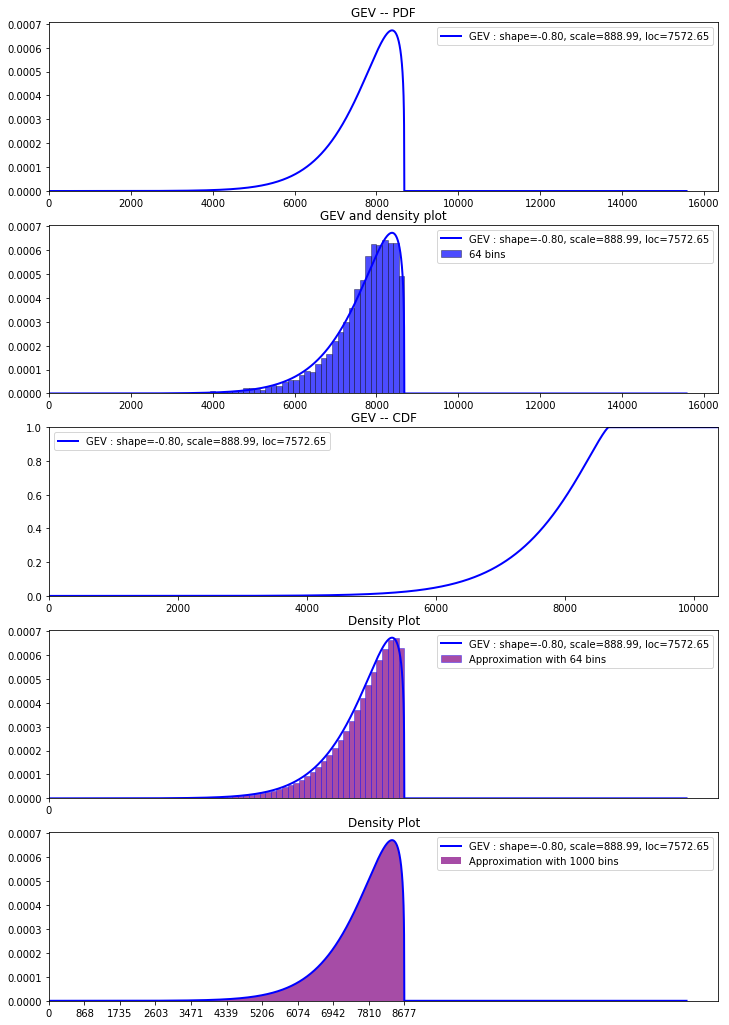

In [28]:
fig, axes = plt.subplots(5, 1)
ax0, ax1, ax2, ax3, ax4 = axes
# WIDTH, HEIGHT
fig.set_size_inches(12, 18)

plot_pdf(dista['x'], dista, ax=ax0, color='blue', linewidth=2, label=makelabel(dista))

plot_pdf(dista['x'], dista, ax=ax1, color='blue', linewidth=2, label=makelabel(dista))
plot_density(edgesa, hista, ax=ax1, color='blue',
             label='{0:d} bins'.format(hista.size), alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_title('{0:s} and density plot'.format(dista['name']))

plot_cdf(dista['xcdf'], dista, ax=ax2, color='blue', linewidth=2, label=makelabel(dista))

a_densa, a_edgesa = density_approx(dista, approx_lower, approx_upper, 64)
plot_pdf(dista['x'], dista, ax=ax3, color='blue', linewidth=2, label=makelabel(dista))
plot_density(a_edgesa, a_densa, ax=ax3, color='purple', 
             label='Approximation with {0:d} bins'.format(a_densa.size), alpha=0.7, edgecolor='blue', linewidth=0.5)
ax3.set_xticks(a_edgesa[0:np.newaxis:100])

a_densa, a_edgesa = density_approx(dista, approx_lower, approx_upper, approx_bins)
plot_pdf(dista['x'], dista, ax=ax4, color='blue', linewidth=2, label=makelabel(dista))
plot_density(a_edgesa, a_densa, ax=ax4, color='purple', label='Approximation with {0:d} bins'.format(a_densa.size), alpha=0.7)
ax4.set_xticks(a_edgesa[0:np.newaxis:100])

mpld3.disable_notebook()

In [29]:
data = []

dist_map = dict()

for c_rkfpath in rkflist:
    aux = getbasename(c_rkfpath).split('_', 1)
    c_rkname = aux[1]
    
    c_rk, c_nl, c_bounds = read_and_preprocess(c_rkfpath, l, scl, cvt)
    c_tl = c_rk[k:]

    c_dist = fit_distribution(c_tl, tp)
    
    c_dens, c_edges = density_approx(c_dist, approx_lower, approx_upper, approx_bins)
    
    EMD = earth_movers_distance(a_densa, a_edgesa, c_dens, c_edges)
    KLD_A = kullback_leibler_distance(a_densa, a_edgesa, c_dens, c_edges)
    KLD_C = kullback_leibler_distance(c_dens, c_edges, a_densa, a_edgesa)
    
    pos_c_a = get_rank_position(nla, c_rkname)
    pos_a_c = get_rank_position(c_nl, rkname)
    
    data.append((c_rkname, EMD, KLD_A, KLD_C, pos_c_a, pos_a_c))
    dist_map[c_rkname] = c_dist
    
ncols = 4
nrows = len(data)
                
dt = dict(names=('name', 'EMD', 'KLD Qy', 'KLD Rkd', 'pos. Rkd in Qy', 'pos. Qy in Rkd'), 
          formats=('U100', np.float32, np.float32, np.float32, np.int32, np.int32))
data = np.array(data, dtype=dt)

_ = np.nan_to_num(data['KLD Qy'], False)
_ = np.nan_to_num(data['KLD Rkd'], False)

### Original Rank (for reference)

In [30]:
plyrank(nla[:nrows], rka[:nrows], "{0:s} Top {1:d}".format(rkname, nrows))

### EMD sorted
We take the 20 first ranked results and sort them by the EMD of their distribution in comparison to the query's distribution.

The columns are:
* **#**: column number (for reference)
* **name**: object name
* **EMD**: Earth Movers Distance value computed
* **KLD QY**: Kullback-Leibler Dissimilarity value. The Qy suffix indicates that it was computed from the query to the ranked object, since it is assymetric
* **KLD Rkd**: Kullback-Leibler Dissimilarity value. The Rkd suffix indicates that it was computed from the ranked object to the query, since it is assymetric
* **pos. Rkd in Qy**: Position of the ranked object in the query's rank
* **pos. Qy in Rkd**: Position of the query in the ranked object's rank

In [31]:
data.sort(order=('EMD'))

plytable(data, dt['names'])

### Kullback-Leibler Query to Ranked sorted

In [32]:
data.sort(order=('KLD Qy'))

plytable(data, dt['names'])

### Kullback-Leibler Ranked to Query sorted

In [33]:
data.sort(order=('KLD Rkd'))

plytable(data, dt['names'])

### Graphical Distribution Comparison
EMD sorted

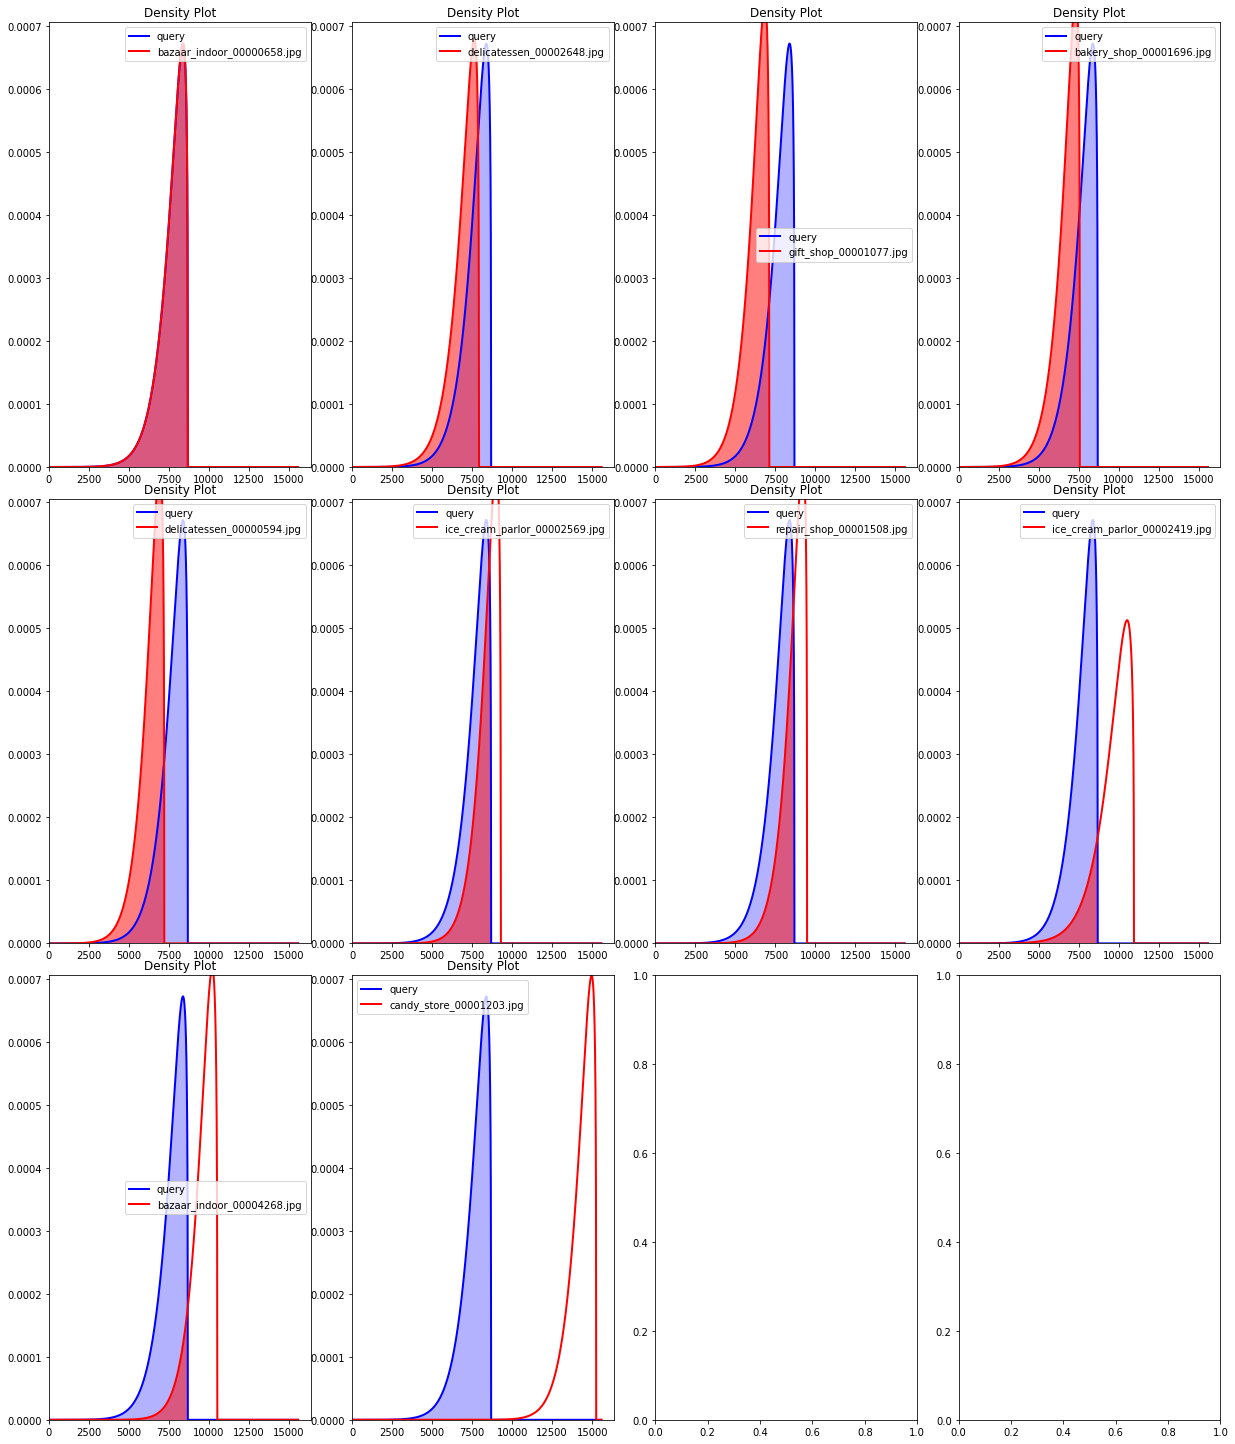

In [34]:
data.sort(order=('EMD'))

sr = int(np.ceil(nrows/4))
fig, axes = plt.subplots(sr, 4)
fig.set_size_inches(17, 20)
fig.tight_layout()

for i, a in enumerate(axes.reshape(-1)):
    
    if i >= nrows:
        break
    key, _, _, _, p, _ = data[i]
    d = dist_map[key]
    
    get_distribution_values(d, 10000, boundsa)
    c_dens, c_edges = density_approx(d, approx_lower, approx_upper, 1000)
    d['density'] = c_dens
    d['edges'] = c_edges
    
    plot_pdf(dista['x'], dista, ax=a, color='blue', label='query', linewidth=2)
    plot_density(a_edgesa, a_densa, ax=a, color='blue', alpha=0.3)
    
    plot_pdf(d['x'], d, ax=a, color='red', label=key, linewidth=2)
    plot_density(c_edges, c_dens, ax=a, color='red', alpha=0.5)

In [35]:
s_hmap_emd = np.zeros((nrows, nrows), dtype=np.float64)
hmap_emd = np.zeros((nrows, nrows), dtype=np.float64)
hmap_kld = np.zeros((nrows, nrows), dtype=np.float64)

# Non Sorted
for i in range(nrows):
    
    key_r = nla[i]
    d_row = dist_map[key_r]
    dens_r = d_row['density']
    edges_r = d_row['edges']
    
    for j in range(nrows):
        
        key_c = nla[j]
        d_col = dist_map[key_c]
        dens_c = d_col['density']
        edges_c = d_col['edges']
        
        EMD = earth_movers_distance(dens_r, edges_r, dens_c, edges_c)
        KLD = kullback_leibler_distance(dens_r, edges_r, dens_c, edges_c)
        hmap_emd[i, j] = EMD
        hmap_kld[i, j] = KLD

# Sorted
for i in range(nrows):
    
    key_r, _, _, _, _, _ = data[i]
    d_row = dist_map[key_r]
    dens_r = d_row['density']
    edges_r = d_row['edges']
    
    for j in range(nrows):
        
        key_c, _, _, _, _, _ = data[j]
        d_col = dist_map[key_c]
        dens_c = d_col['density']
        edges_c = d_col['edges']
        
        EMD = earth_movers_distance(dens_r, edges_r, dens_c, edges_c)
        KLD = kullback_leibler_distance(dens_r, edges_r, dens_c, edges_c)
        s_hmap_emd[i, j] = EMD

### EMD Heatmap in Query->Ranked EMD-sorted order
Rows and columns are sorted according to their EMD to the query image.

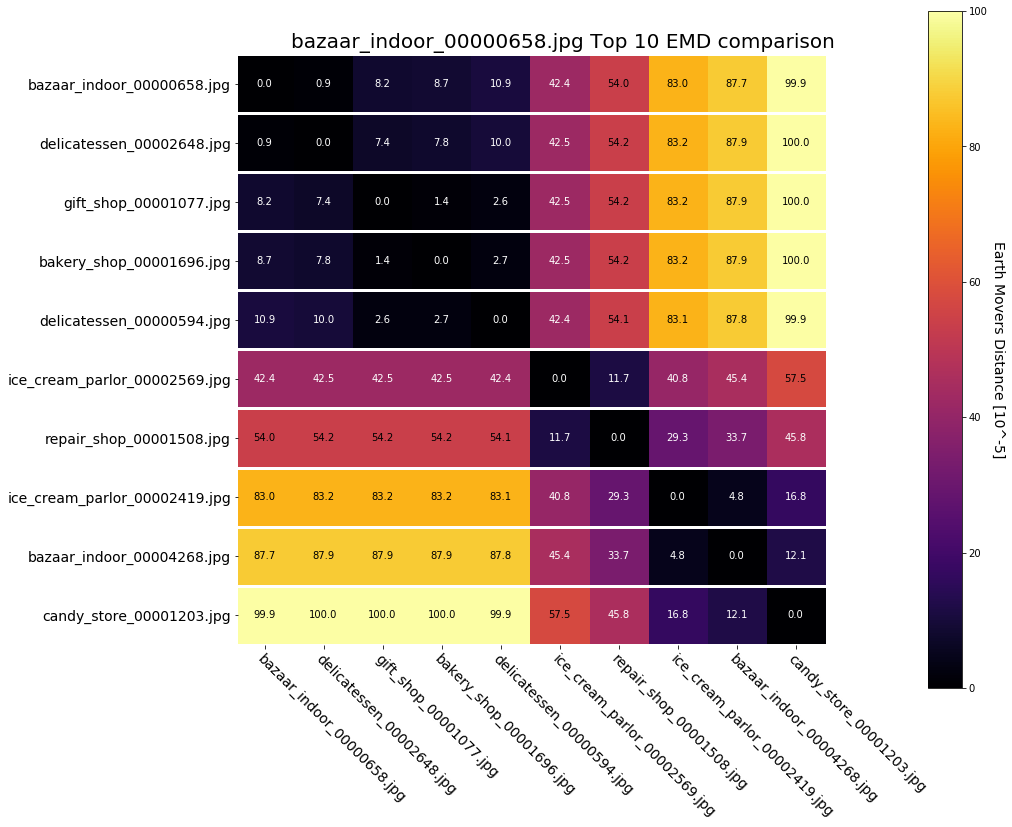

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
fig.tight_layout()  
im = heatmap(s_hmap_emd*100000, data['name'], data['name'], ax=ax, cbarlabel="Earth Movers Distance [10^-5]", 
                                        title="{0:s} Top {1:d} EMD comparison".format(rkname, nrows), cmap='inferno')
texts = annotate_heatmap(im, valfmt="{x:.1f}", textcolors=['white', 'black'])

#print('Is symmetric: ', np.allclose(s_hmap, s_hmap.T))

### EMD Heatmap in Rank-sorted order
Rows and columns are shown according to their position in the original rank.

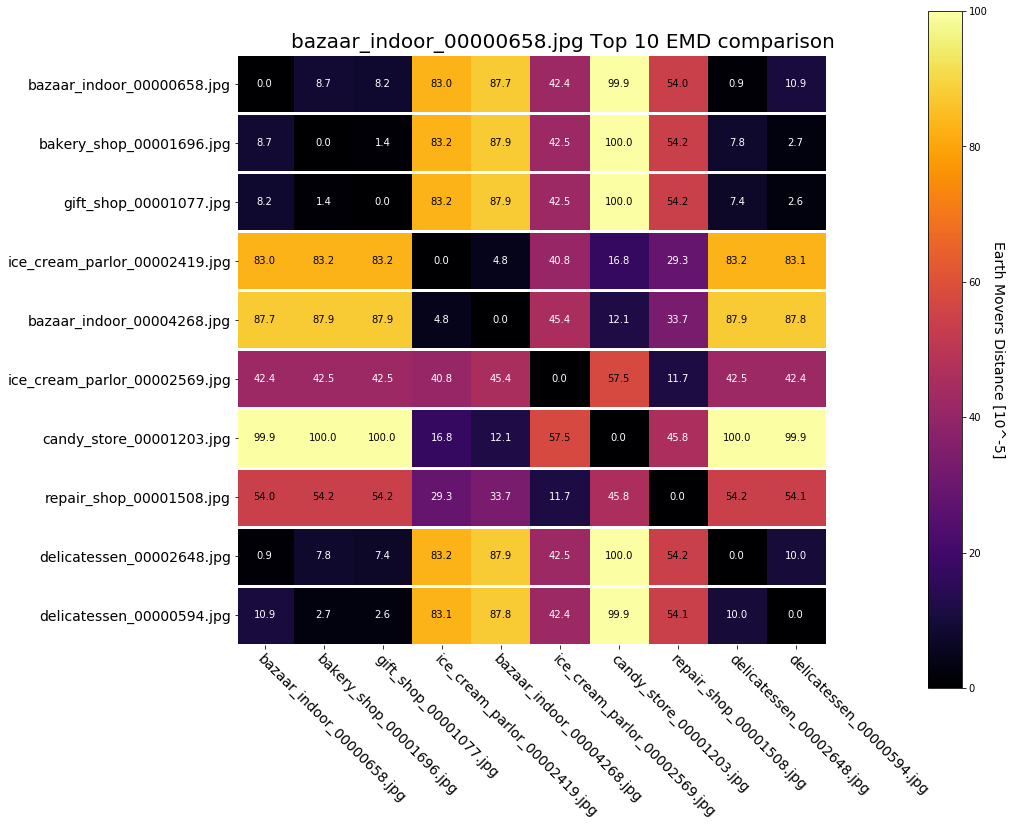

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
fig.tight_layout()  
im = heatmap(hmap_emd*100000, nla[:nrows], nla[:nrows], ax=ax, cbarlabel="Earth Movers Distance [10^-5]", 
                                        title="{0:s} Top {1:d} EMD comparison".format(rkname, nrows), cmap='inferno')
texts = annotate_heatmap(im, valfmt="{x:.1f}", textcolors=['white', 'black'])

#print('Is symmetric: ', np.allclose(hmap, hmap.T))

### KLD Heatmap in Rank-sorted order
Rows and columns are shown according to their position in the original rank.

/home/alberto/miniconda3/envs/albpy/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning:


/home/alberto/miniconda3/envs/albpy/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning:




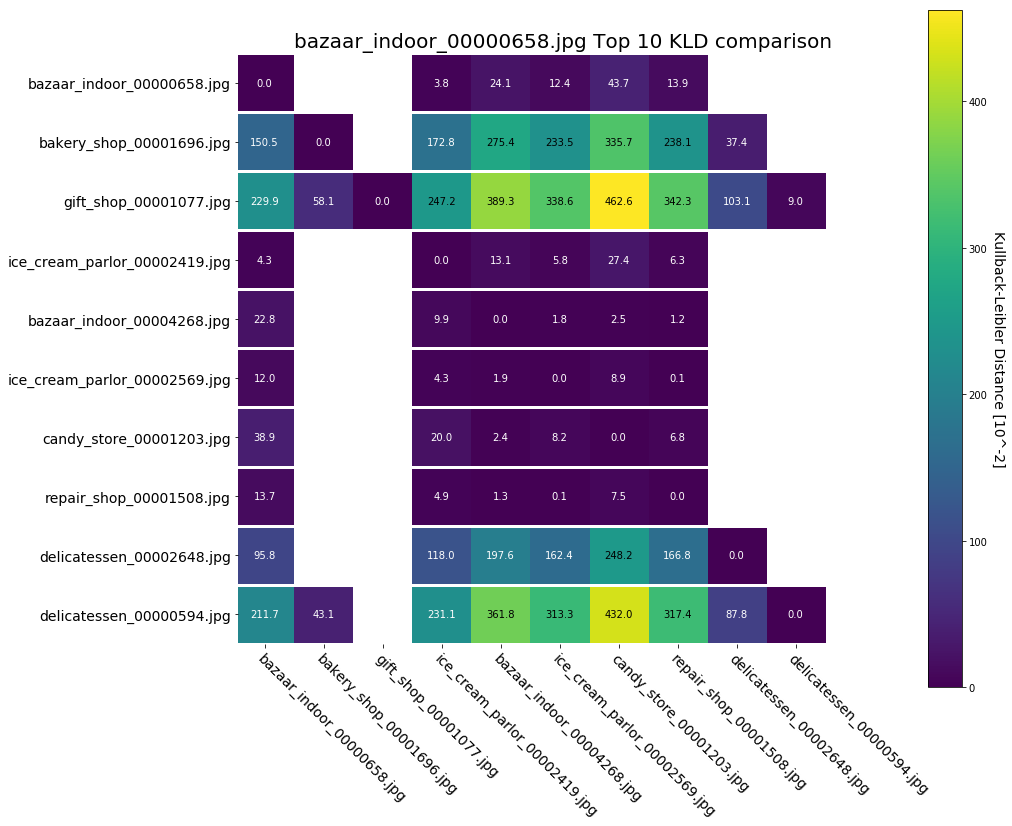

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
fig.tight_layout()  
im = heatmap(hmap_kld*100, nla[:nrows], nla[:nrows], ax=ax, cbarlabel="Kullback-Leibler Distance [10^-2]", 
                                        title="{0:s} Top {1:d} KLD comparison".format(rkname, nrows), cmap='viridis')
texts = annotate_heatmap(im, valfmt="{x:.1f}", textcolors=['white', 'black'])

#print('Is symmetric: ', np.allclose(hmap, hmap.T))

### EMD Feature
The EMD Feature is constructed by removing the (i, j) position, which is always 0, from the above vector. 

Text(81.125,0.5,'Rank Position')

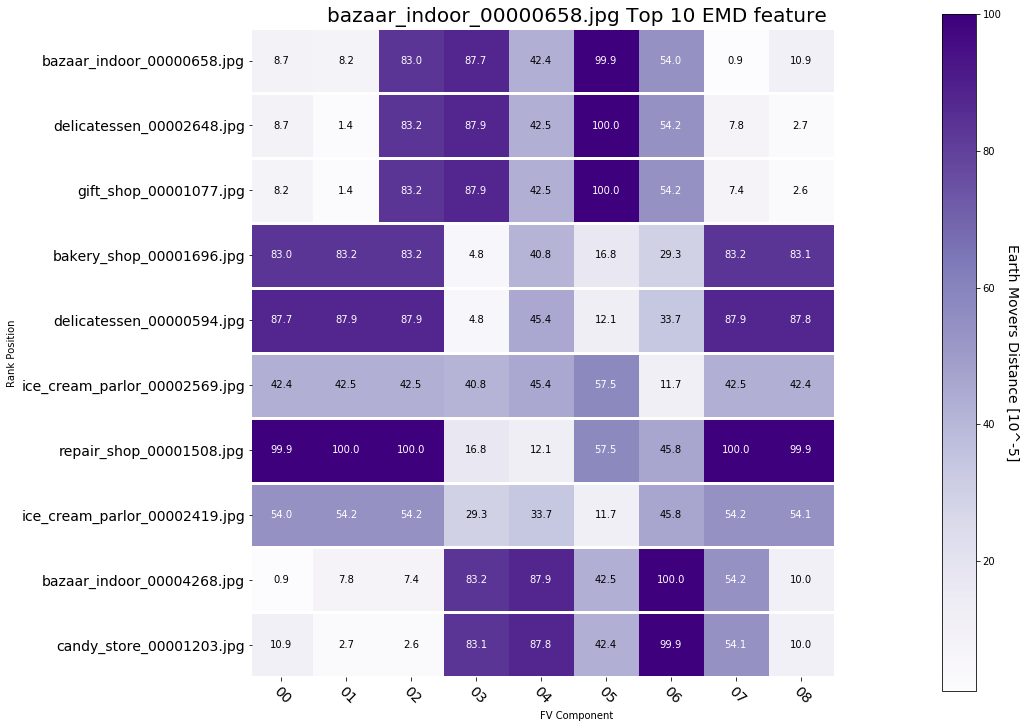

In [56]:
featmap = [[hmap_emd[i, j] for j in range(hmap_emd.shape[1]) if j != i] for i in range(hmap_emd.shape[0])]
featmap = np.array(featmap, dtype=np.float64)

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
fig.tight_layout()  

colnames = ["{0:02d}".format(x) for x in range(nrows-1)]
im = heatmap(featmap*100000, data['name'], colnames, ax=ax, cbarlabel="Earth Movers Distance [10^-5]", 
                                        title="{0:s} Top {1:d} EMD feature".format(rkname, nrows), cmap='Purples')
texts = annotate_heatmap(im, valfmt="{x:.1f}", textcolors=['black', 'white'])

ax.set_xlabel("FV Component")
ax.set_ylabel("Rank Position")
        

### Scaled

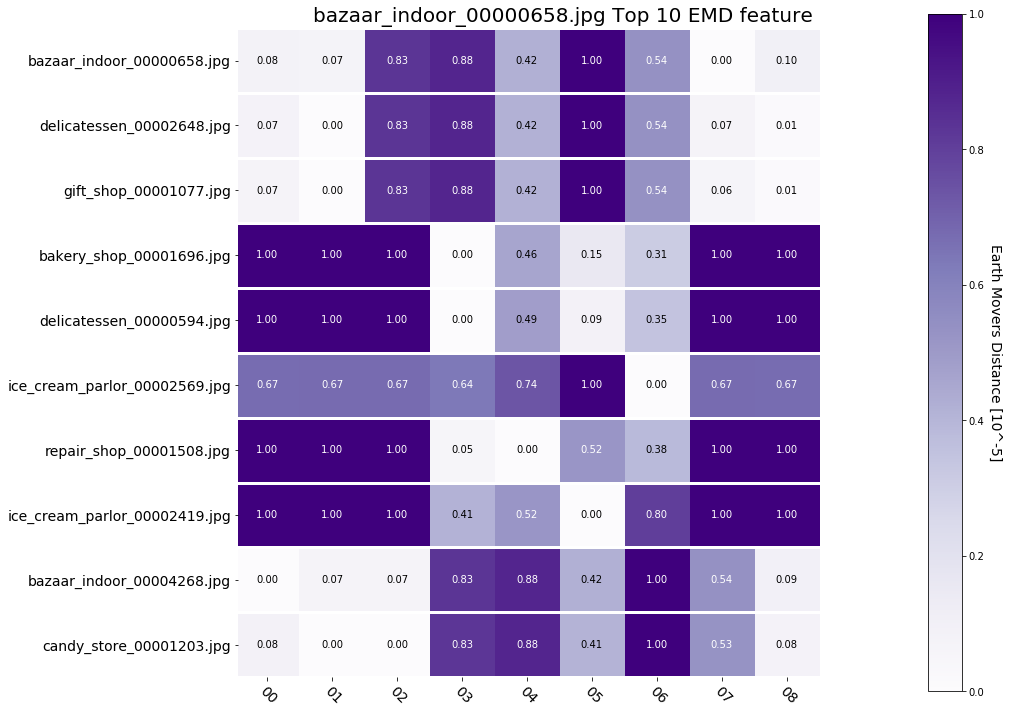

In [40]:
mmxs = MinMaxScaler((0, 1))

featmap_scl = mmxs.fit_transform(featmap.T).T

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
fig.tight_layout()  

colnames = ["{0:02d}".format(x) for x in range(nrows-1)]
im = heatmap(featmap_scl, data['name'], colnames, ax=ax, cbarlabel="Earth Movers Distance [10^-5]", 
                                        title="{0:s} Top {1:d} EMD feature".format(rkname, nrows), cmap='Purples')
texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=['black', 'white'])

### Bhattacharyya coefficient (BCF) Feature

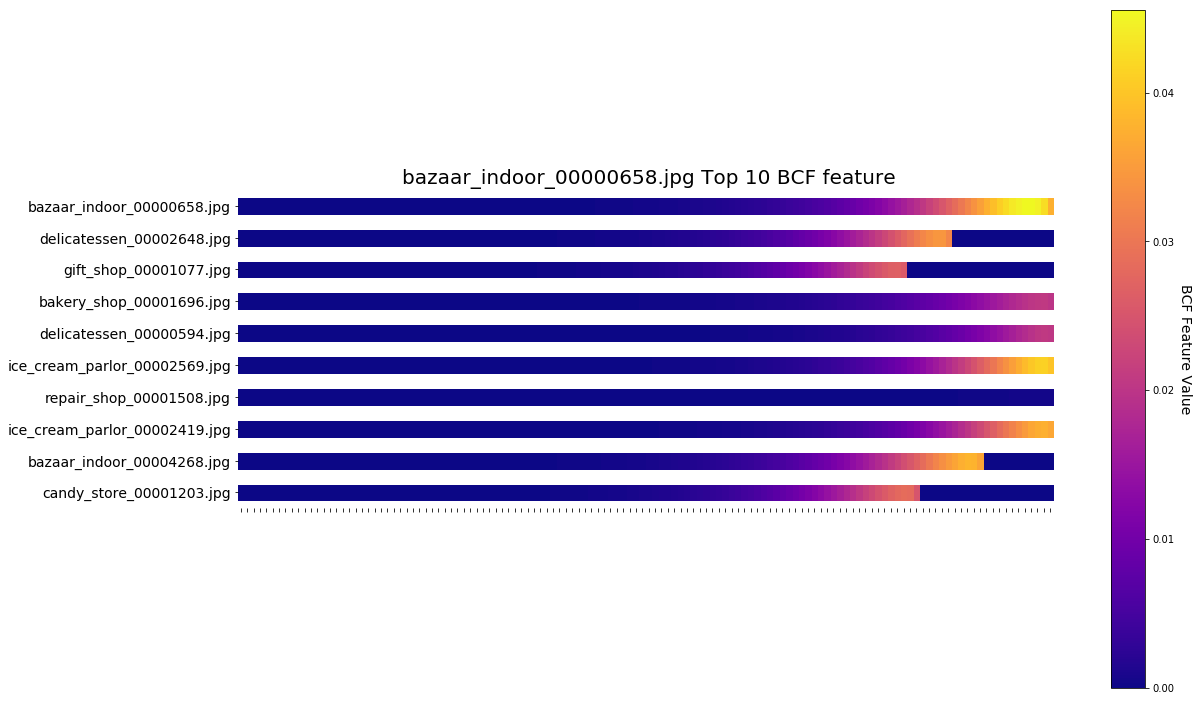

In [41]:
bcffeatures = []

a_dens, a_edges = density_approx(dista, approx_lower, approx_upper, 128)

# Non Sorted
for i in range(nrows):
    
    key_r = nla[i]
    d_row = dist_map[key_r]
    r_dens, r_edges = density_approx(d_row, approx_lower, approx_upper, 128)
    bcffeatures.append(bcf_feature(a_dens, a_edges, r_dens, r_edges))
    
bcffeatures = np.vstack(bcffeatures)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
fig.tight_layout()

im = heatmap(bcffeatures, data['name'], [], ax=ax, gridwidth=15, cbarlabel="BCF Feature Value", 
             title="{0:s} Top {1:d} BCF feature".format(rkname, nrows), cmap='plasma', aspect=5)

### Scaled

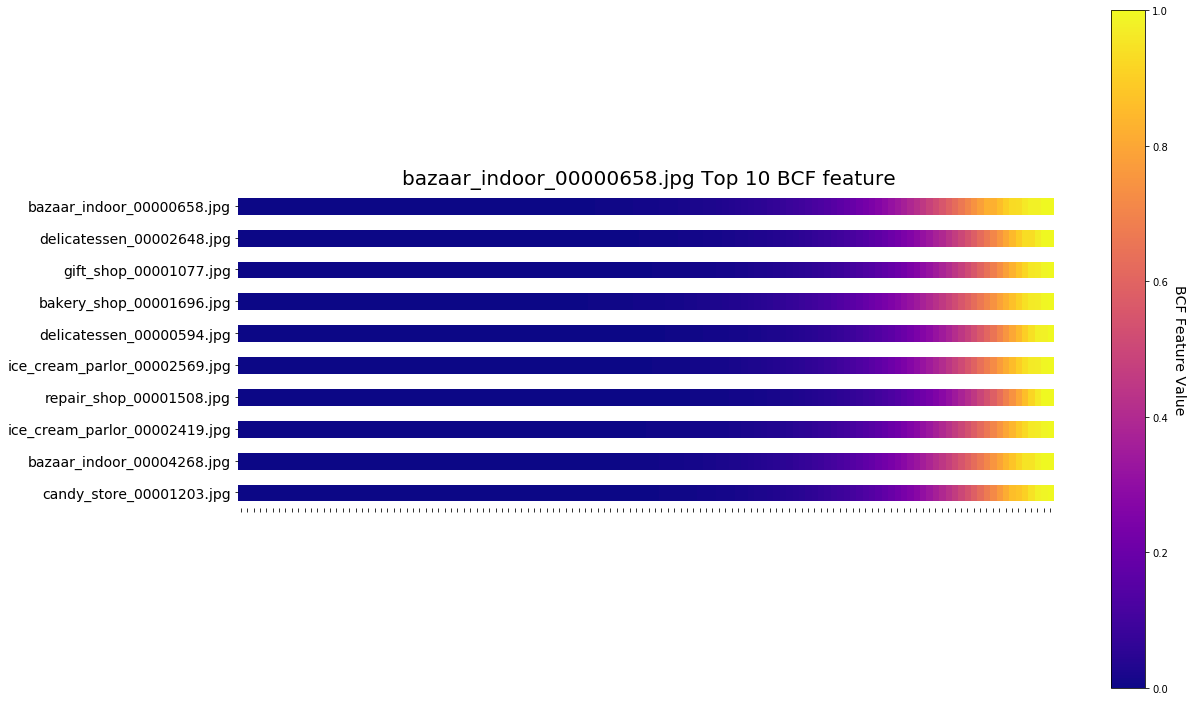

In [42]:
mmxs = MinMaxScaler((0, 1))

bcffeatures_scl = mmxs.fit_transform(bcffeatures.T).T

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
fig.tight_layout()

im = heatmap(np.sort(bcffeatures_scl, axis=1), data['name'], [], ax=ax, gridwidth=15, cbarlabel="BCF Feature Value", 
             title="{0:s} Top {1:d} BCF feature".format(rkname, nrows), cmap='plasma', aspect=5)